<a href="https://colab.research.google.com/github/DougChul/Ferroelectric-ThinFilm-Poling/blob/main/KAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cp= 2.2134999999999996e-10  F


<ipython-input-8-f7334702e098>:39: RuntimeWarning: overflow encountered in exp
  tau=np.where(((Ea)/abs(E-Eoff))**alpha >100,tau0*np.exp(100),tau0*np.exp(((Ea)/abs(E-Eoff))**alpha))
<ipython-input-8-f7334702e098>:46: RuntimeWarning: overflow encountered in exp
  tau=np.where(((Ea)/abs(E-Eoff))**alpha >100,tau0*np.exp(100),tau0*np.exp(((Ea)/abs(E-Eoff))**alpha))


1.0
0.1


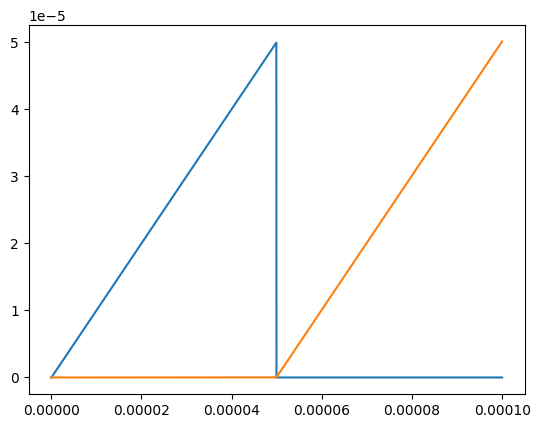

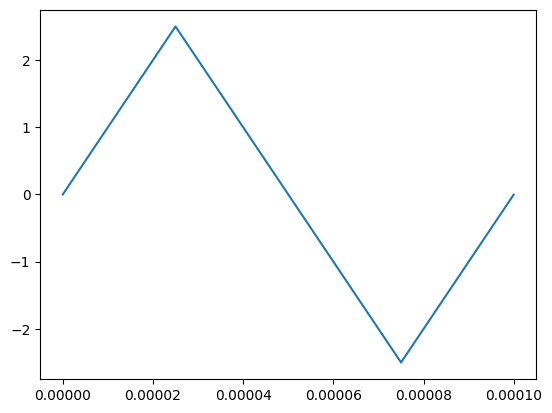

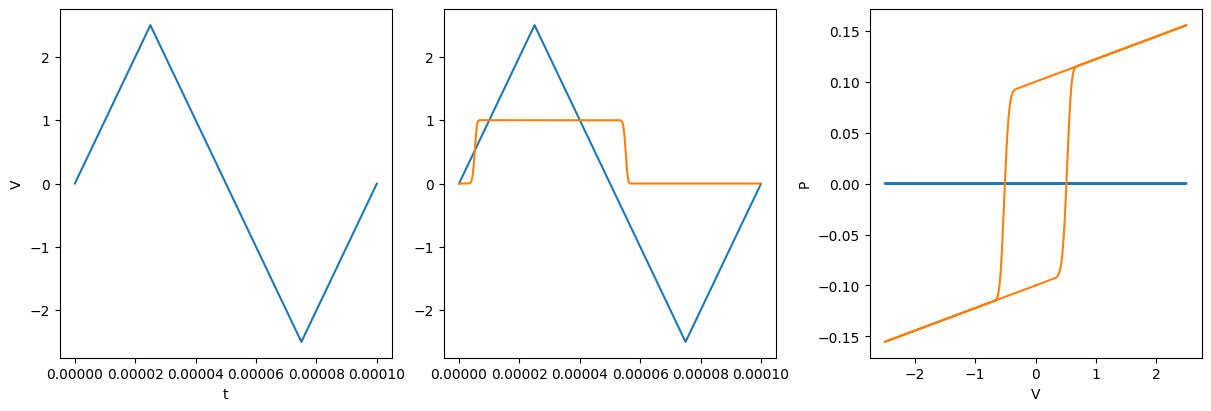

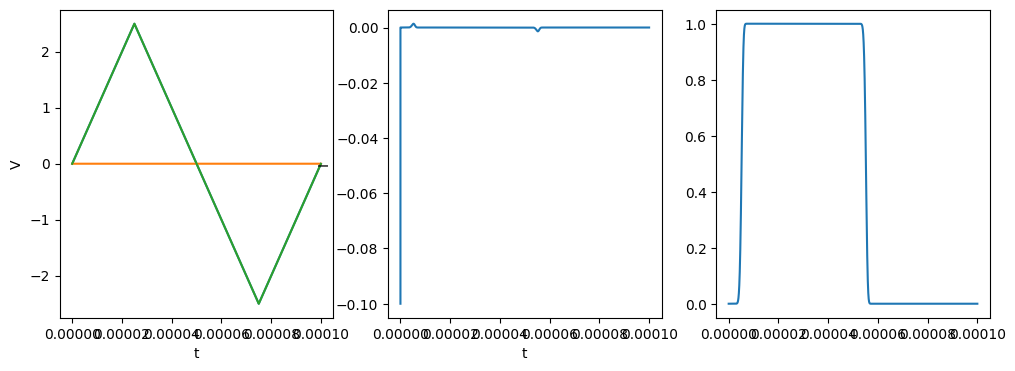

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# # Dynamic model for FE (based on KAI)
# - 2022 IEEE TED 논문 참고

# In[1]:


# 목록 확인 -*- coding: utf-8 -*-
get_ipython().run_line_magic('matplotlib', 'inline')
import csv
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import gamma
import scipy.interpolate as ip
from scipy.interpolate import splrep, splev
from scipy.signal import savgol_filter
import os

# pd.set_option('display.max_rows',None)

Thickness = 10e-9 # [m]
Area = 10000e-12 # [m2]
Ps=0.1 # [c/m2]

# Set parameter for Merz' law
alpha = 2  # second dimension
tau0 = 500e-9 #[s]
Eoff = 0 #1.5e+8 #2e+8 #[V/m]
Ea = 67740947 #1.5e+8 #[V/m]

# tau
def tauP(E):  # 위 아래 식 동일함.
    if E>Eoff:   #|E|가 매우 작으면 tau 고정값(큰값임). 그게 아닌 보통의 경우 원래 tau 식 따라감. Bigger E smaller tau
        tau=np.where(((Ea)/abs(E-Eoff))**alpha >100,tau0*np.exp(100),tau0*np.exp(((Ea)/abs(E-Eoff))**alpha))
    else:   # E<0 이면 어차피 수식에서 쓰이지 않음. (1dt 곱해지므로 무시 가능일듯..)
        tau = tau0*np.exp(100)
    return tau

def tauM(E):
    if E<Eoff:
        tau=np.where(((Ea)/abs(E-Eoff))**alpha >100,tau0*np.exp(100),tau0*np.exp(((Ea)/abs(E-Eoff))**alpha))
    else:
        tau = tau0*np.exp(100)
    return tau

# beta
B = 2

# Parallel linear element
Cp = 8.854e-12*25*Area/Thickness #[F]
Rp = 5e9 #[ohm]
Rs = 50 #[ohm]
print('Cp=',Cp,' F')


# In[2]:


f = 10000 #[Hz]
Vamp = 2.5 #[V] Emax=3e8
# #sin wave
# def Vext(t):
#     return Vamp*np.sin(2*np.pi*f*t)
#triangular wave
def Vext(t):
    return Vamp*4*f*abs(divmod(t-1/4/f,1/f)[1]-1/2/f)-Vamp


# In[3]:


dt = 0.1e-7
ilist=list(range(1,10000)) # 199999 길이의 배열.
tP = np.zeros(len(ilist)) # Tinc+
tM = np.zeros(len(ilist)) # Tinc-
T = np.zeros(len(ilist)) # Time
Vap = np.ones(len(ilist))*1e-21   # 배열 1로 채워서 선언.
V_Cp = np.zeros(len(ilist))
Q_Cp = np.zeros(len(ilist))
p = np.zeros(len(ilist))

for i in ilist[1:len(ilist)-1]: # i=2 부터 i=199999 배열 index 0 부터 시작이므로 last index = len(list) - 1 이다.
    T[i] = T[i-1]+dt # 기본 time은 accumulation of fixed dt
    tP[i] = tP[i-1]+dt # 딱히 0이어도 문제 없을거 같은데, if 1dt면 미소값이므로 0으로 근사 가능 될거고,
    tM[i] = tM[i-1]+dt # 일단 둘 다 dt 넣어놓고 계산 후에 아래에서 다시 처리,
    Vap[i] = Vext(T[i]) #가해진 삼각파 or sin wave Voltage directly apply to ferro.
    ## 1dt값 0 취급해서 계산하면, E-field 음수 양수 일 때, 수식이 조금 다른데...
    ## 그래서 아래 코드로 변경했더니, 처음에 교수님이 고민하던 그 그래프가 나왔네..
    #애초에 {P | 0<P<1} 이므로 1-P 라는 식이 나올거고, 초기화를 시켜주려면 식이 변형되어야 함.
    #p[i] = p[i-1]-B*(tM[i])**(B-1)/tauM(Vap[i]/Thickness)**B*dt*(1-p[i-1])+B*(tP[i])**(B-1)/tauP(Vap[i]/Thickness)**B*dt*(1-p[i-1])
    p[i] = (1-B*(tM[i])**(B-1)/tauM(Vap[i]/Thickness)**B*dt)*p[i-1]+B*(tP[i])**(B-1)/tauP(Vap[i]/Thickness)**B*dt*(1-p[i-1])
    tP[i] = np.where((Vap[i]/Thickness-Eoff)<Ea*0.01,0,tP[i-1]+dt) # E field 음수면 tP=0
    tM[i] = np.where((Vap[i]/Thickness-Eoff)>Ea*0.01,0,tM[i-1]+dt) # E field 양수면 tM=0

plt.figure()
plt.plot(T,tP)
plt.plot(T,tM)
plt.figure()
plt.plot(T,Vap)


# In[4]:


t = np.array(T)
Vap = np.array(Vap)
Q_Cp = Cp*Vap

P = 2*Ps*(p-0.5) # 2Ps는 미분에 포함 안된 계수.

print(np.max(p))

print(np.max(P))
V_Cp = Q_Cp/Cp
I_Rp = Vap/Rp
Q_Rp = np.cumsum(I_Rp)*dt
V_Rs = Vap-V_Cp
I_Rs = V_Rs/Rs
I_Cp = np.diff(P,prepend=0)

plt.figure(figsize=(12,4),constrained_layout=True)
plt.subplot(1,3,1);plt.xlabel('t');plt.ylabel('V')
plt.plot(T,Vap)
plt.subplot(1,3,2)
plt.plot(T,Vap)
plt.plot(T,p)
plt.subplot(1,3,3);plt.xlabel('V');plt.ylabel('P')
# plt.plot(Vap,Q_Cp/Area)
plt.plot(Vap,Q_Rp/Area)
plt.plot(Vap,P+(Q_Cp+Q_Rp)/Area)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1);plt.xlabel('t');plt.ylabel('V')
plt.plot(T,V_Cp)
plt.plot(T,V_Rs)
plt.plot(T,Vap)
plt.subplot(1,3,2);plt.xlabel('t');plt.ylabel('I')
plt.plot(T,I_Cp)
# plt.plot(T,I_Rs)
# plt.plot(T,I_Rp)
plt.subplot(1,3,3)
# plt.plot(Vap,I_Rs)
plt.plot(T,p)
